In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt

sns.set()

import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import keras
import keras.metrics as metrics
from keras.models import Sequential
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import re
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(colored('\x1B[1mDownloading Libraries\n1.Stop Words\n2.Wordnet \n3.averaged_perceptron_tagger','magenta'))
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

1.Stop Words
2.Wordnet 
3.averaged_perceptron_tagger
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
print(colored('\x1B[1mLoading dataset....','magenta'))
schl = pd.read_json("/content/drive/MyDrive/Files/NLP/Sarcasm_Headlines_Dataset.json", lines=True)
schl.head()

Loading dataset....


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
print(colored('\x1B[1mGetting shape of data....','magenta'))
schl.shape

Getting shape of data....


(26709, 3)

In [5]:
print(colored('\x1B[1mChecking if any null value present or not','magenta'))
schl.isnull().sum().sum()

Checking if any null value present or not


0

In [6]:
print(colored('\x1B[1mDescripition of all attributes','magenta'))
schl.describe(include='object')

Descripition of all attributes


,article_link,headline
count,26709,26709
unique,26708,26602
top,https://www.huffingtonpost.comhttp://nymag.com...,the 20 funniest tweets from women this week
freq,2,10


### `https://www.huffingtonpost.comhttp://nymag.com` is the most frequent article link
 ### `sunday roundup`	is most frequent headline

In [7]:
print(colored('\x1B[1mKeeping only relevant columns','magenta'))
print(colored('''\x1B[1mDroping 'article_link' column''','green'))
schl = schl.drop('article_link', axis=1)

Keeping only relevant columns
Droping 'article_link' column


In [8]:
print(colored('\x1B[1mChecking if any different labels for the same headline present or not\n','magenta'))

count_of_target = 0
for target in schl.groupby(schl.headline).is_sarcastic.agg(list):
    if(len(set(list(target))) != 1):
        count_of_target += 1

if count_of_target == 0:
  print(colored('\x1B[1mNo different labels for the same headline','green'))
else:
  print(colored('\x1B[1m%d different labels for the same headline'%count_of_target,'green'))


Checking if any different labels for the same headline present or not

No different labels for the same headline


In [9]:
print(colored('''\x1B[1mPie Chart of 'sarcastic' or 'not sarcastic' ''','magenta'))
import plotly.express as px
px.pie(schl,names='is_sarcastic',labels=['not sarcastic','sarcastic'],title='Sarchastic')

Pie Chart of 'sarcastic' or 'not sarcastic' 


Words used for sarcasm


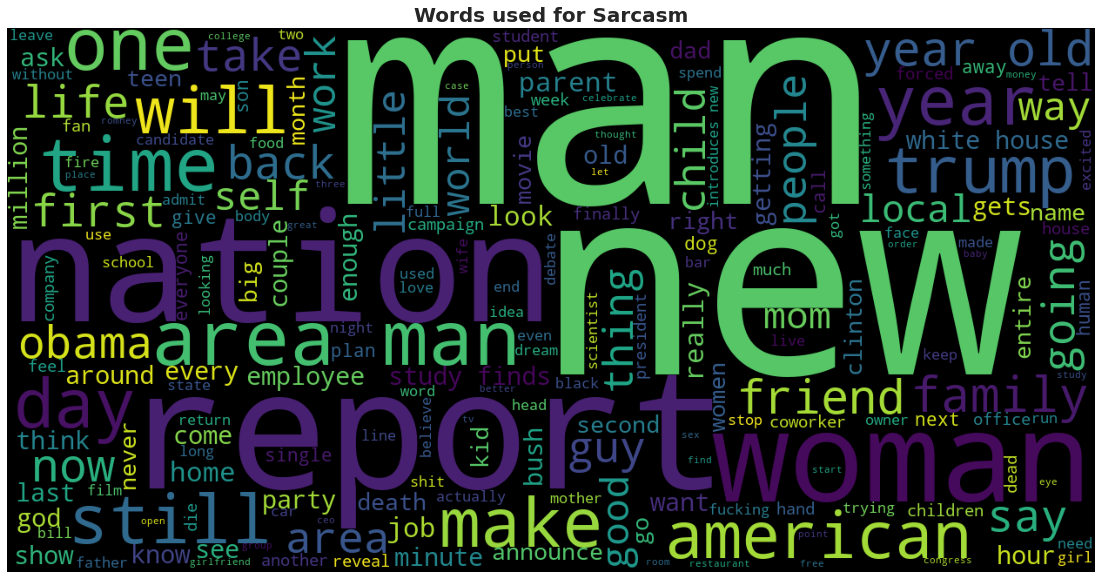

In [10]:
print(colored('\x1B[1mWords used for sarcasm','magenta'))
all_keywords = " ".join(line for line in schl[schl.is_sarcastic==1].headline)
word_cloud= WordCloud(width=1250, height=625, max_font_size=350, 
                      random_state=42).generate(all_keywords)
plt.figure(figsize=(20, 10))
plt.title("Words used for Sarcasm", size=20, weight="bold")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

Words used for no sarcasm


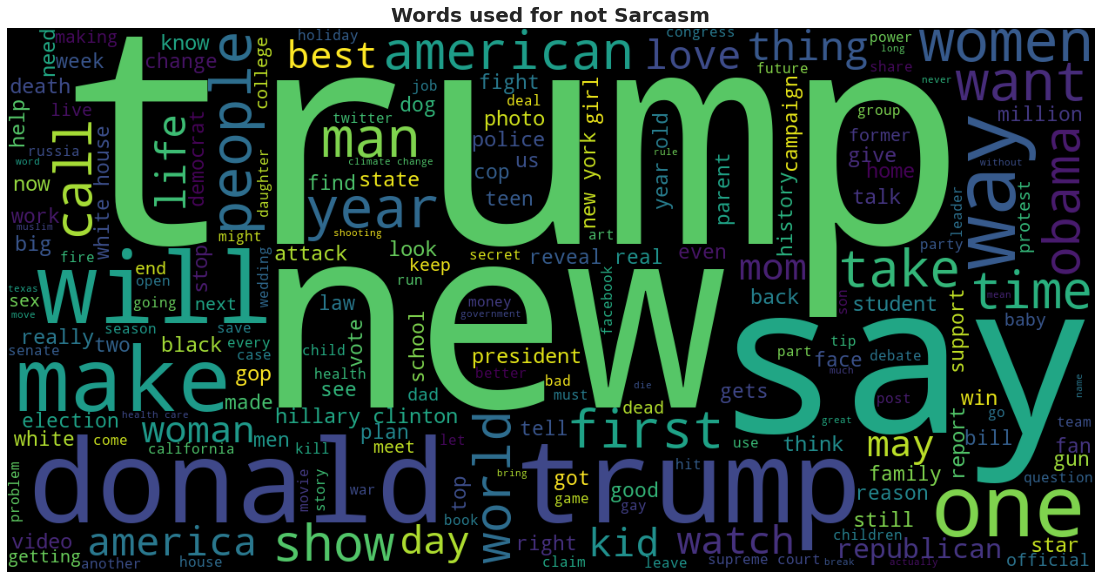

In [11]:
print(colored('\x1B[1mWords used for no sarcasm','magenta'))
all_keywords = " ".join(line for line in schl[schl.is_sarcastic==0].headline)
word_cloud= WordCloud(width=1250, height=625, max_font_size=350, 
                      random_state=42).generate(all_keywords)
plt.figure(figsize=(20, 10))
plt.title("Words used for not Sarcasm", size=20, weight="bold")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

### Data Preprocessing
Some of the common text preprocessing / cleaning steps are:

- [  ] remove unwanted space 
- [  ] remove unwanted characters / remove Punctuation
- [  ] remove Stopwords 
- [  ] convert text to lowercase


In [12]:
from tqdm import tqdm
def clean_text1(text):
    cleaned_data=[]
    for sent in tqdm(text):
        sent=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sent)
        words=[word for word in sent.split() if word not in stopwords.words('english')]
        cleaned_data.append(' '.join(words))
    
    return cleaned_data

In [13]:
schl.headline=clean_text1(schl.headline)

100%|██████████| 26709/26709 [00:32<00:00, 830.84it/s]


In [14]:
print(colored('\x1B[1mOrignal text','green'))
df = schl.head(10).copy()
df['headline']

Orignal text


0    former versace store clerk sues secret 'black ...
1    'roseanne' revival catches thorny political mo...
2    mom starting fear son's web series closest thi...
3    boehner wants wife listen, come alternative de...
4    j.k. rowling wishes snape happy birthday magic...
5                              advancing world's women
6               fascinating case eating lab-grown meat
7                   ceo send kids school, work company
8    top snake handler leaves sinking huckabee camp...
9    friday's morning email: inside trump's presser...
Name: headline, dtype: object

In [15]:
print(colored('\x1B[1mFunction for removing punctuations','green'))
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('','',PUNCT_TO_REMOVE))

Function for removing punctuations


In [16]:
print(colored('\x1B[1mFunction for removing stop word','green'))
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

Function for removing stop word


In [17]:
print(colored('\x1B[1mFunction for Lemmatization','green'))
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

Function for Lemmatization


In [18]:
print(colored('\x1B[1mUsing Pipeline for pre-processing the text','magenta'))
print(colored('''\x1B[1m1.Removing Puntucation\n2.Removing Stop Words\n3.Lemmatization\n4.Lower-CaseStrip\n5.Strip''','green'))
def clean_text2(text):
  
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = lemmatize_words(text)
    text = text.lower()
    text = text.strip()
    return text

schl["headline"] = schl["headline"].map(lambda text : clean_text2(text))

Using Pipeline for pre-processing the text
1.Removing Puntucation
2.Removing Stop Words
3.Lemmatization
4.Lower-CaseStrip
5.Strip


In [19]:
df = pd.DataFrame(list(zip(df['headline'], schl['headline'].head(10))),
               columns =['Orignal Text', 'Final Text'])
df

,Orignal Text,Final Text
0,former versace store clerk sues secret 'black ...,former versace store clerk sue secret black co...
1,'roseanne' revival catches thorny political mo...,roseanne revival catch thorny political mood w...
2,mom starting fear son's web series closest thi...,mom start fear son web series closest thing gr...
3,"boehner wants wife listen, come alternative de...",boehner want wife listen come alternative debt...
4,j.k. rowling wishes snape happy birthday magic...,jk rowling wish snape happy birthday magical way
5,advancing world's women,advance world woman
6,fascinating case eating lab-grown meat,fascinate case eat labgrown meat
7,"ceo send kids school, work company",ceo send kid school work company
8,top snake handler leaves sinking huckabee camp...,top snake handler leave sink huckabee campaign
9,friday's morning email: inside trump's presser...,friday morning email inside trump presser age


In [20]:
print(colored('\x1B[1mFinal text','magenta'))

Final text


In [21]:
max_len = len(max(schl.headline))
print(colored('\x1B[1mThe length of the largest sarcasm headline sentence is %d'%max_len,'magenta'))

The length of the largest sarcasm headline sentence is 39


In [22]:
num_words = len((schl.headline))
print(colored('\x1B[1mThe length of the largest sarcasm headline sentence is %d'%num_words,'magenta'))

The length of the largest sarcasm headline sentence is 26709


In [23]:
print(colored('\x1B[1mTokenizing using Tokenizer() the data;it creates a dictionary of words and their numbers','magenta'))
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#tokenizer = Tokenizer(num_words= 50000, lower=True,oov_token="<Out of Vocabulary>")
#tokenizer = Tokenizer(lower=True,oov_token="<Out of Vocabulary>")
tokenizer = Tokenizer(num_words)

tokenizer.fit_on_texts(schl.headline)
word_idx = tokenizer.word_index
print(word_idx) 

Tokenizing using Tokenizer() the data;it creates a dictionary of words and their numbers
{'trump': 1, 'new': 2, 'man': 3, 'get': 4, 'woman': 5, 'make': 6, 'say': 7, 'report': 8, 'u': 9, 'one': 10, 'go': 11, 'day': 12, 'time': 13, 'year': 14, 'area': 15, 'take': 16, 'donald': 17, 'find': 18, 'american': 19, 'like': 20, 'first': 21, 'people': 22, 'life': 23, 'way': 24, 'show': 25, 'nation': 26, 'house': 27, 'thing': 28, 'world': 29, 'obama': 30, 'call': 31, 'look': 32, 'give': 33, 'clinton': 34, 'back': 35, 'want': 36, 'still': 37, 'white': 38, 'know': 39, 'family': 40, 'come': 41, 'child': 42, 'watch': 43, 'think': 44, 'state': 45, 'work': 46, 'plan': 47, 'need': 48, 'love': 49, 'school': 50, 'could': 51, 'tell': 52, 'use': 53, 'right': 54, 'see': 55, 'mom': 56, 'change': 57, 'black': 58, 'big': 59, 'kill': 60, 'gop': 61, 'study': 62, 'kid': 63, 'star': 64, 'good': 65, 'parent': 66, 'bill': 67, '5': 68, 'president': 69, 'talk': 70, 'would': 71, 'police': 72, 'home': 73, 'best': 74, 'dea

In [24]:
print(colored('\x1B[1mCreating features and labels','magenta'))
X = schl['headline'].values
y = schl['is_sarcastic'].values
X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size=.2, random_state=202)
X_valid, X_test, y_valid, y_test = train_test_split(X_Test, y_Test, test_size=.2, random_state=202)

Creating features and labels


In [25]:
print(colored('\x1B[1mTotal size of vobulary','magenta'))
print(len(word_idx))

Total size of vobulary
23314


In [26]:
print(colored('\x1B[1mTokenizing using Tokenizer() the data;it creates a dictionary of words and their numbers','magenta'))
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words)

tokenizer.fit_on_texts(X_train)
word_idx = tokenizer.word_index
print(word_idx) 

Tokenizing using Tokenizer() the data;it creates a dictionary of words and their numbers
{'trump': 1, 'new': 2, 'man': 3, 'get': 4, 'woman': 5, 'make': 6, 'say': 7, 'report': 8, 'u': 9, 'one': 10, 'day': 11, 'year': 12, 'go': 13, 'area': 14, 'time': 15, 'take': 16, 'find': 17, 'american': 18, 'donald': 19, 'like': 20, 'people': 21, 'way': 22, 'first': 23, 'show': 24, 'life': 25, 'thing': 26, 'world': 27, 'house': 28, 'obama': 29, 'nation': 30, 'look': 31, 'call': 32, 'back': 33, 'give': 34, 'still': 35, 'clinton': 36, 'white': 37, 'know': 38, 'family': 39, 'want': 40, 'think': 41, 'come': 42, 'work': 43, 'child': 44, 'watch': 45, 'state': 46, 'plan': 47, 'need': 48, 'tell': 49, 'love': 50, 'change': 51, 'school': 52, 'could': 53, 'right': 54, 'see': 55, 'use': 56, 'good': 57, 'study': 58, 'big': 59, 'star': 60, 'kill': 61, 'black': 62, 'gop': 63, 'kid': 64, 'president': 65, 'mom': 66, 'parent': 67, '5': 68, 'police': 69, 'bill': 70, 'talk': 71, 'help': 72, 'really': 73, 'last': 74, 'wo

In [27]:
print(colored('\x1B[1mCreating sequences for every sentence\n','magenta'))
train_sqns= tokenizer.texts_to_sequences(X_train)
valid_sqns= tokenizer.texts_to_sequences(X_valid)
test_sqns= tokenizer.texts_to_sequences(X_test)

for i in range(0,3):
  x=random.choice(range(len(X_train)))
  print(colored('\x1B[1mHeadline sentence','green'))
  print(X_train[x])
  print(colored('\x1B[1mTokenized sentence','magenta'))
  print(train_sqns[x])
  print('\n')

Creating sequences for every sentence

Headline sentence
coworker hastily leave break room avoid come boom spoiler
Tokenized sentence
[727, 5201, 79, 95, 340, 705, 42, 3956, 3980]


Headline sentence
chrissy teigen 2 word hater insinuated gold digger
Tokenized sentence
[1491, 1652, 148, 241, 4223, 16340, 1047, 16341]


Headline sentence
banjowielding matt damon make lastminute bid best original song
Tokenized sentence
[12556, 1241, 3134, 6, 2217, 1285, 82, 1919, 451]




In [28]:
print(colored('\x1B[1mPadding the sentences to make scentence of same size, as the scentences are of different sizes','magenta'))
print(colored('''\x1B[1mThis will add 0's to the smaller sequences\n''','green'))

X_train_sqns= pad_sequences(train_sqns,padding="post",truncating='post',
                            maxlen=max_len)

X_valid_sqns= pad_sequences(valid_sqns,padding="post",truncating='post',
                            maxlen=max_len)

X_test_sqns= pad_sequences(test_sqns,padding="post",truncating='post',
                            maxlen=max_len)


for i in range(0,3):
  x=random.choice(range(len(X_train)))
  print(colored('\x1B[1mLength of headline scentnce number %d is %d\nHeadline'%(x,(len(X_train[x].split()))),'blue'))
  print(X_train[x])
  print(colored('\n\x1B[1mPadded sentence','magenta'))
  print(X_train_sqns[x])
  print(colored('\x1B[1mLength of padded scentnce','blue'))
  print(len(X_train_sqns[x]))
  print('\n')

Padding the sentences to make scentence of same size, as the scentences are of different sizes
This will add 0's to the smaller sequences

Length of headline scentnce number 11433 is 8
Headline
health insurer fire volley new battle public option

Padded sentence
[   77  3851   106 16066     2   724   314  1391     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
Length of padded scentnce
39


Length of headline scentnce number 9563 is 5
Headline
disappointed silence proud domestic ignatians

Padded sentence
[ 3173  1115   749  1120 15110     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
Length of padded scentnce
39


Length of headline scentnce number 13052 is 6
Headline
5 foolproof muffin kick b

#### As we see that, though the length of headline sentences are different but the padding sequence sentences are same.

[]

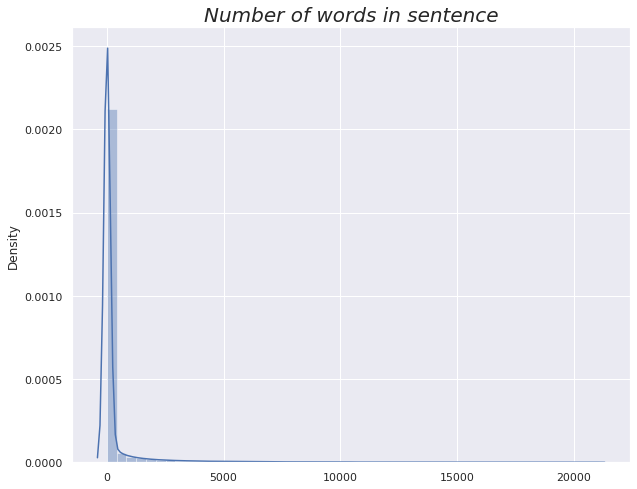

In [29]:
plt.figure(figsize=(10,8))
sns.distplot(X_train_sqns)
plt.title('Number of words in sentence',fontdict={'size':20,'style':'italic'})
plt.plot()

In [30]:
word_counts=pd.DataFrame(tokenizer.word_counts.items(),columns=['words','counts']).sort_values(by='counts',ascending=False)

In [31]:
word_counts.head(10)

,words,counts
54,trump,1282
55,new,1221
21,man,1102
23,get,728
139,woman,655
114,make,605
7,say,583
220,report,501
204,u,458
764,one,434


In [32]:
word_counts.tail(10)

,words,counts
12194,goldstein,1
12182,overwhelming,1
12183,erdogan,1
12184,orban,1
12185,multipronged,1
12188,oxfam,1
12190,medically,1
12192,anonymously,1
12193,regretfully,1
20922,tenuous,1


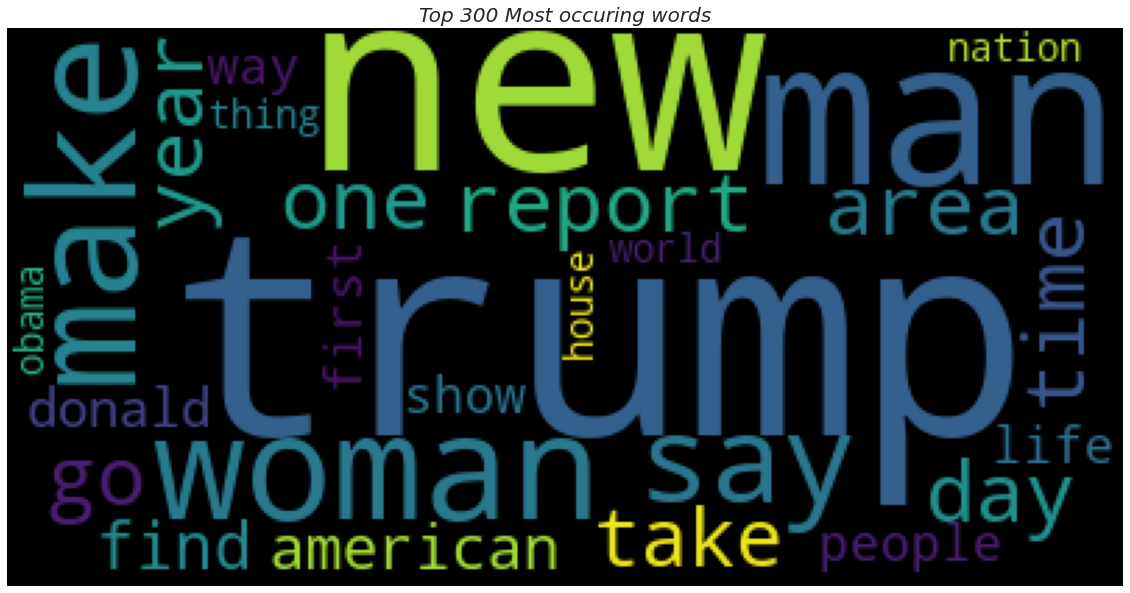

In [33]:
top_300_words=word_counts.words[:30]
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in top_300_words))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.title('Top 300 Most occuring words',fontdict={'size':20,'style':'italic'})
plt.imshow(wc)

In [34]:
print(colored('\x1B[1mMaking dictionary of all words in corpus from pre-trained glove embeddings','magenta'))
embedding = {}
with open("/content/drive/MyDrive/Files/NLP/glove.6B/glove.6B.300d.txt") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding[word] = vectors
file.close()

Making dictionary of all words in corpus from pre-trained glove embeddings


In [35]:
print(colored('\x1B[1mCreating a weight matrix for GloVe embeddings','magenta'))
embedding_matrix = np.zeros((num_words, 300))
#embedding_matrix = np.zeros()

for i, word in tokenizer.index_word.items():
    if i < (num_words+1):
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

Creating a weight matrix for GloVe embeddings


In [36]:
print(colored('\x1B[1mShape of embedding','magenta'))
embedding_matrix.shape

Shape of embedding


(26709, 300)

In [37]:
print(colored('\x1B[1mShape of training, validation and test sets','magenta'))
print('Shape of X train',X_train_sqns.shape,'Shape of Y train',y_train.shape)
print('Shape of X valid',X_valid_sqns.shape,'Shape of Y valid',y_valid.shape)
print('Shape of X test',X_test_sqns.shape,'Shape of Y test',y_test.shape)

Shape of training, validation and test sets
Shape of X train (21367, 39) Shape of Y train (21367,)
Shape of X valid (4273, 39) Shape of Y valid (4273,)
Shape of X test (1069, 39) Shape of Y test (1069,)


In [38]:
print(colored('\x1B[1mBuilding Simple RNN model','magenta'))
simpleRNN = model = Sequential()

simpleRNN.add(Embedding(input_dim=num_words, output_dim=300, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=max_len, trainable=False))
simpleRNN.add(SimpleRNN(64, dropout=0.1))
simpleRNN.add(Dense(1, activation='sigmoid'))

Building Simple RNN model


In [39]:
print(colored('\x1B[1mSummary of Simple RNN model','magenta'))
simpleRNN.summary()

Summary of Simple RNN model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 300)           8012700   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                23360     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 8,036,125
Trainable params: 23,425
Non-trainable params: 8,012,700
_________________________________________________________________


In [40]:
print(colored('\x1B[1mCompling Simple RNN model','magenta'))
simpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Compling Simple RNN model


In [41]:
print(colored('\x1B[1mSetting earlystoping','magenta'))
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min', min_lr=1e-6)

Setting earlystoping


In [42]:
print(colored('\x1B[1mFittting the model','magenta'))
history1 = simpleRNN.fit(X_train_sqns, y_train, epochs=20, batch_size=1024, validation_data=(X_valid_sqns, y_valid),verbose=2,callbacks=[earlyStopping, reduce_lr_loss])

Fittting the model
Epoch 1/20
21/21 - 27s - loss: 0.6562 - accuracy: 0.6056 - val_loss: 0.6097 - val_accuracy: 0.6768
Epoch 2/20
21/21 - 5s - loss: 0.5869 - accuracy: 0.6953 - val_loss: 0.5730 - val_accuracy: 0.7103
Epoch 3/20
21/21 - 5s - loss: 0.5517 - accuracy: 0.7284 - val_loss: 0.5484 - val_accuracy: 0.7351
Epoch 4/20
21/21 - 5s - loss: 0.5296 - accuracy: 0.7421 - val_loss: 0.5411 - val_accuracy: 0.7367
Epoch 5/20
21/21 - 5s - loss: 0.5104 - accuracy: 0.7558 - val_loss: 0.5455 - val_accuracy: 0.7297
Epoch 6/20
21/21 - 5s - loss: 0.5014 - accuracy: 0.7604 - val_loss: 0.5278 - val_accuracy: 0.7426
Epoch 7/20
21/21 - 5s - loss: 0.4883 - accuracy: 0.7682 - val_loss: 0.5356 - val_accuracy: 0.7444
Epoch 8/20
21/21 - 5s - loss: 0.4779 - accuracy: 0.7744 - val_loss: 0.5265 - val_accuracy: 0.7468
Epoch 9/20
21/21 - 5s - loss: 0.4664 - accuracy: 0.7815 - val_loss: 0.5340 - val_accuracy: 0.7470
Epoch 10/20
21/21 - 5s - loss: 0.4610 - accuracy: 0.7841 - val_loss: 0.5334 - val_accuracy: 0.7454

In [43]:
print(colored('\x1B[1mEvaluating the model','green'))
scores = simpleRNN.evaluate(X_test_sqns, y_test, verbose=0)
print(colored('\x1B[1mAccuracy: %.2f%%' % (scores[1]*100),'blue'))

Evaluating the model
Accuracy: 75.58%


				Accuracy analysis of LSTM-Model



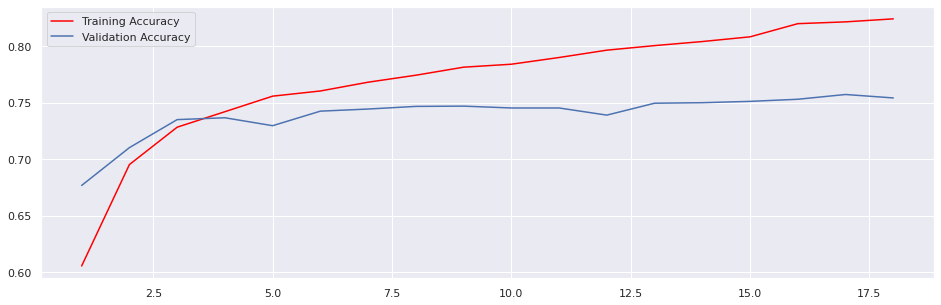

In [44]:
print(colored('\x1B[1m\t\t\t\tAccuracy analysis of LSTM-Model\n','green'))
plt.figure(figsize=(16,5))
epochs = range(1, len(history1.history['accuracy'])+1)
plt.plot(epochs, history1.history['accuracy'], 'b', label='Training Accuracy', color='red')
plt.plot(epochs, history1.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend()
plt.show()

				Loss analysis graph of LSTM-Model



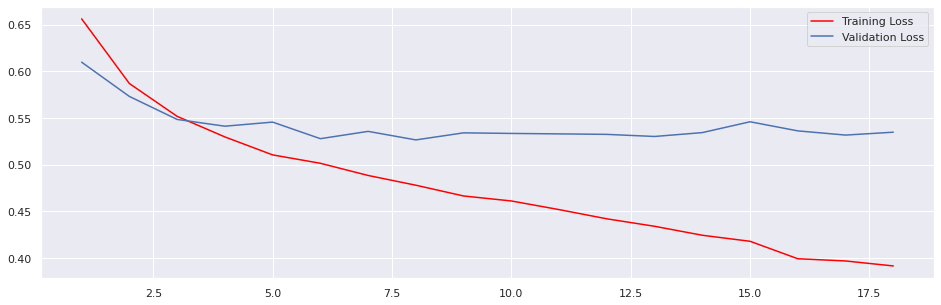

In [45]:
print(colored('\x1B[1m\t\t\t\tLoss analysis graph of LSTM-Model\n','green'))
plt.figure(figsize=(16,5))
epochs = range(1, len(history1.history['accuracy'])+1)
plt.plot(epochs, history1.history['loss'], 'b', label='Training Loss', color='red')
plt.plot(epochs, history1.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.show()

In [46]:
print(colored('\x1B[1mCalssification Report','blue'))
print(classification_report(y_test, simpleRNN.predict_classes(X_test_sqns)))

Calssification Report
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       593
           1       0.74      0.69      0.71       476

    accuracy                           0.76      1069
   macro avg       0.75      0.75      0.75      1069
weighted avg       0.76      0.76      0.75      1069



In [47]:
cm=confusion_matrix(y_test,simpleRNN.predict_classes(X_test_sqns))

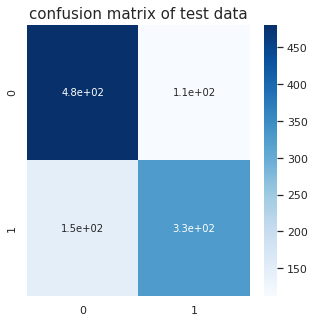

In [48]:
plt.figure(figsize=(5,5))
sns.heatmap(cm,xticklabels=['0','1'],yticklabels=['0','1'],annot=True,cmap='Blues')
plt.title('confusion matrix of test data',fontdict={'size':15})
plt.show()

## LSTM Model

In [49]:
print(colored('\x1B[1mBuilding LSTM model','magenta'))
lstm_model = Sequential()

lstm_model.add(Embedding(input_dim=num_words, output_dim=300, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=max_len, trainable=False))
lstm_model.add(LSTM(50, dropout=0.1))
lstm_model.add(Dense(1, activation='sigmoid'))

Building LSTM model


In [50]:
print(colored('\x1B[1mSummary of LSTM model','magenta'))
lstm_model.summary()

Summary of LSTM model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 39, 300)           8012700   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 8,082,951
Trainable params: 70,251
Non-trainable params: 8,012,700
_________________________________________________________________


In [51]:
print(colored('\x1B[1mcomplining LSTM model','magenta'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

complining LSTM model


In [52]:
print(colored('\x1B[1mSetting earlystoping','magenta'))
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min', min_lr=1e-6)

Setting earlystoping


In [53]:
print(colored('\x1B[1mFittting the model','magenta'))
history2 = lstm_model.fit(X_train_sqns, y_train, epochs=20, batch_size=1024, validation_data=(X_valid_sqns, y_valid),verbose=2,callbacks=[earlyStopping, reduce_lr_loss])

Fittting the model
Epoch 1/20
21/21 - 13s - loss: 0.6755 - accuracy: 0.5741 - val_loss: 0.6208 - val_accuracy: 0.6541
Epoch 2/20
21/21 - 9s - loss: 0.5860 - accuracy: 0.6970 - val_loss: 0.5596 - val_accuracy: 0.7203
Epoch 3/20
21/21 - 9s - loss: 0.5346 - accuracy: 0.7388 - val_loss: 0.5322 - val_accuracy: 0.7393
Epoch 4/20
21/21 - 9s - loss: 0.5064 - accuracy: 0.7576 - val_loss: 0.5049 - val_accuracy: 0.7559
Epoch 5/20
21/21 - 9s - loss: 0.4726 - accuracy: 0.7774 - val_loss: 0.4913 - val_accuracy: 0.7590
Epoch 6/20
21/21 - 9s - loss: 0.4385 - accuracy: 0.7977 - val_loss: 0.4584 - val_accuracy: 0.7821
Epoch 7/20
21/21 - 9s - loss: 0.4077 - accuracy: 0.8166 - val_loss: 0.4445 - val_accuracy: 0.7819
Epoch 8/20
21/21 - 9s - loss: 0.3755 - accuracy: 0.8337 - val_loss: 0.4395 - val_accuracy: 0.7950
Epoch 9/20
21/21 - 9s - loss: 0.3524 - accuracy: 0.8439 - val_loss: 0.4444 - val_accuracy: 0.7987
Epoch 10/20
21/21 - 9s - loss: 0.3356 - accuracy: 0.8545 - val_loss: 0.4413 - val_accuracy: 0.8027

				Accuracy analysis of LSTM-Model



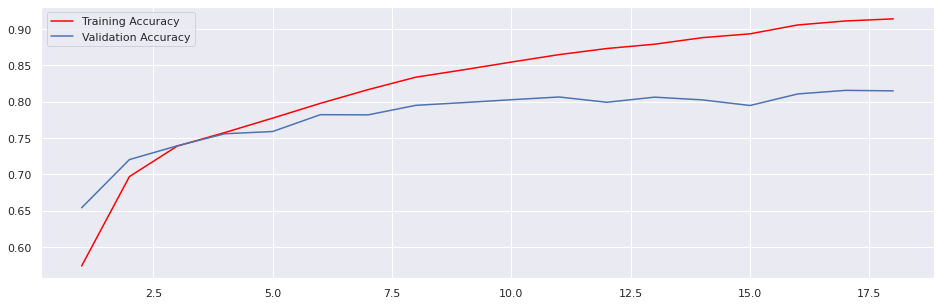

In [54]:
print(colored('\x1B[1m\t\t\t\tAccuracy analysis of LSTM-Model\n','green'))
plt.figure(figsize=(16,5))
epochs = range(1, len(history2.history['accuracy'])+1)
plt.plot(epochs, history2.history['accuracy'], 'b', label='Training Accuracy', color='red')
plt.plot(epochs, history2.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend()
plt.show()

				Loss analysis graph of LSTM-Model



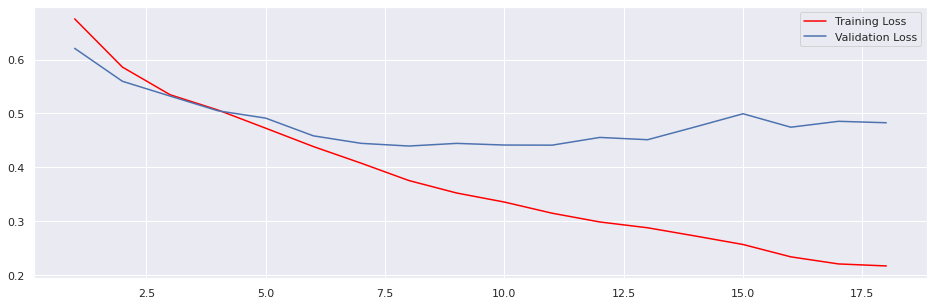

In [55]:
print(colored('\x1B[1m\t\t\t\tLoss analysis graph of LSTM-Model\n','green'))
plt.figure(figsize=(16,5))
epochs = range(1, len(history2.history['accuracy'])+1)
plt.plot(epochs, history2.history['loss'], 'b', label='Training Loss', color='red')
plt.plot(epochs, history2.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.show()

In [56]:
print(colored('\x1B[1mEvaluating the model','green'))
scores = lstm_model.evaluate(X_test_sqns, y_test, verbose=0)
print(colored('\x1B[1mAccuracy: %.2f%%' % (scores[1]*100),'blue'))

Evaluating the model
Accuracy: 79.51%


In [57]:
print(colored('\x1B[1mCalssification Report','blue'))
print(classification_report(y_test, lstm_model.predict_classes(X_test_sqns)))

Calssification Report
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       593
           1       0.81      0.71      0.76       476

    accuracy                           0.80      1069
   macro avg       0.80      0.79      0.79      1069
weighted avg       0.80      0.80      0.79      1069



In [58]:
cm=confusion_matrix(y_test,lstm_model.predict_classes(X_test_sqns))

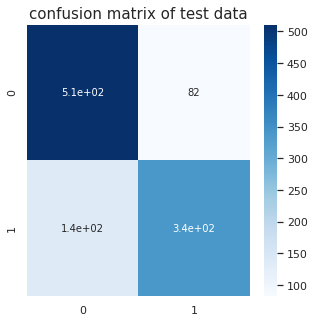

In [59]:
plt.figure(figsize=(5,5))
sns.heatmap(cm,xticklabels=['0','1'],yticklabels=['0','1'],annot=True,cmap='Blues')
plt.title('confusion matrix of test data',fontdict={'size':15})
plt.show()

## Bidirectional LSTM

In [60]:
print(colored('\x1B[1mBuilding Bidirectional LSTM model','magenta'))
biLSTM = Sequential()

biLSTM.add(Embedding(input_dim=num_words, output_dim=300, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=max_len, trainable=False))
biLSTM.add(Bidirectional(LSTM(units=64, recurrent_dropout = 0.3, dropout = 0.3, 
                             return_sequences = True)))
biLSTM.add(Bidirectional(LSTM(units=32, recurrent_dropout = 0.1, dropout = 0.1)))
biLSTM.add(Dense(1, activation='sigmoid'))

Building Bidirectional LSTM model


In [61]:
print(colored('\x1B[1mSummary of Bidirectional LSTM model','magenta'))
biLSTM.summary()

Summary of Bidirectional LSTM model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 39, 300)           8012700   
_________________________________________________________________
bidirectional (Bidirectional (None, 39, 128)           186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 8,240,861
Trainable params: 228,161
Non-trainable params: 8,012,700
_________________________________________________________________


In [62]:
print(colored('\x1B[1mCompling Bidirectional LSTM model','magenta'))
biLSTM.compile(optimizer=keras.optimizers.Adam(lr = 0.01), 
              loss='binary_crossentropy', metrics=['accuracy'])

Compling Bidirectional LSTM model


In [63]:
print(colored('\x1B[1mSetting earlystoping','magenta'))
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min', min_lr=1e-6)

Setting earlystoping


In [64]:
print(colored('\x1B[1mFittting the model','magenta'))
history3 = biLSTM.fit(X_train_sqns, y_train, epochs=20, batch_size=1024, validation_data=(X_valid_sqns, y_valid),verbose=2,callbacks=[earlyStopping, reduce_lr_loss])

Fittting the model
Epoch 1/20
21/21 - 85s - loss: 0.5605 - accuracy: 0.7102 - val_loss: 0.4887 - val_accuracy: 0.7676
Epoch 2/20
21/21 - 63s - loss: 0.4547 - accuracy: 0.7814 - val_loss: 0.4435 - val_accuracy: 0.7868
Epoch 3/20
21/21 - 63s - loss: 0.3896 - accuracy: 0.8218 - val_loss: 0.4281 - val_accuracy: 0.7985
Epoch 4/20
21/21 - 63s - loss: 0.3316 - accuracy: 0.8525 - val_loss: 0.4219 - val_accuracy: 0.8144
Epoch 5/20
21/21 - 63s - loss: 0.2786 - accuracy: 0.8806 - val_loss: 0.4348 - val_accuracy: 0.8116
Epoch 6/20
21/21 - 63s - loss: 0.2405 - accuracy: 0.9010 - val_loss: 0.4572 - val_accuracy: 0.8123
Epoch 7/20
21/21 - 63s - loss: 0.2110 - accuracy: 0.9130 - val_loss: 0.4993 - val_accuracy: 0.8170
Epoch 8/20
21/21 - 63s - loss: 0.1831 - accuracy: 0.9250 - val_loss: 0.5238 - val_accuracy: 0.8165
Epoch 9/20
21/21 - 63s - loss: 0.1698 - accuracy: 0.9334 - val_loss: 0.5619 - val_accuracy: 0.8172
Epoch 10/20
21/21 - 63s - loss: 0.1528 - accuracy: 0.9369 - val_loss: 0.5573 - val_accurac

			Loss analysis graph of biLSTM-Model



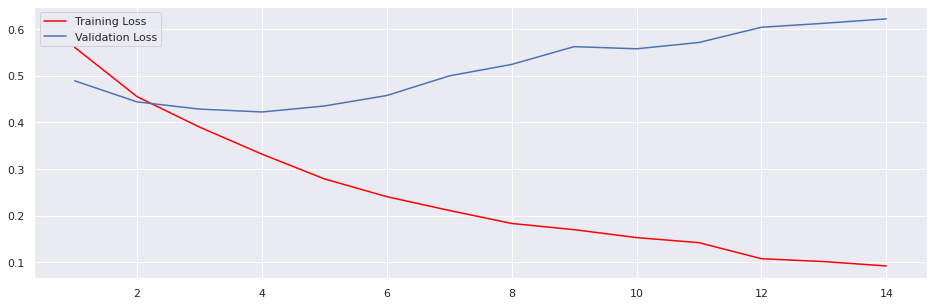

In [65]:
print(colored('\x1B[1m\t\t\tLoss analysis graph of biLSTM-Model\n','green'))
plt.figure(figsize=(16,5))
epochs = range(1, len(history3.history['accuracy'])+1)
plt.plot(epochs, history3.history['loss'], 'b', label='Training Loss', color='red')
plt.plot(epochs, history3.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.show()

				Accuracy analysis of biLSTM-Model



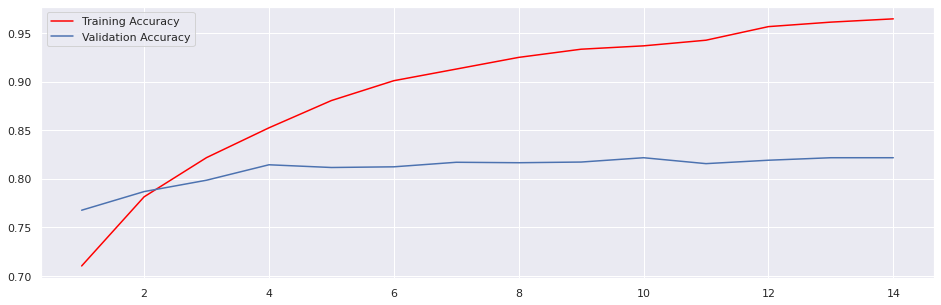

In [66]:
print(colored('\x1B[1m\t\t\t\tAccuracy analysis of biLSTM-Model\n','green'))
plt.figure(figsize=(16,5))
epochs = range(1, len(history3.history['accuracy'])+1)
plt.plot(epochs, history3.history['accuracy'], 'b', label='Training Accuracy', color='red')
plt.plot(epochs, history3.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend()
plt.show()

In [67]:
print(colored('\x1B[1mEvaluating the model','green'))
scores = lstm_model.evaluate(X_test_sqns, y_test, verbose=0)
print(colored('\x1B[1mAccuracy: %.2f%%' % (scores[1]*100),'blue'))

Evaluating the model
Accuracy: 79.51%


In [68]:
print(colored('\x1B[1mCalssification Report','blue'))
print(classification_report(y_test, biLSTM.predict_classes(X_test_sqns)))

Calssification Report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       593
           1       0.81      0.77      0.79       476

    accuracy                           0.82      1069
   macro avg       0.82      0.81      0.81      1069
weighted avg       0.82      0.82      0.82      1069



In [69]:
cm=confusion_matrix(y_test,biLSTM.predict_classes(X_test_sqns))

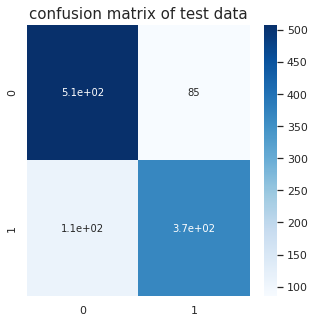

In [70]:
plt.figure(figsize=(5,5))
sns.heatmap(cm,xticklabels=['0','1'],yticklabels=['0','1'],annot=True,cmap='Blues')
plt.title('confusion matrix of test data',fontdict={'size':15})
plt.show()

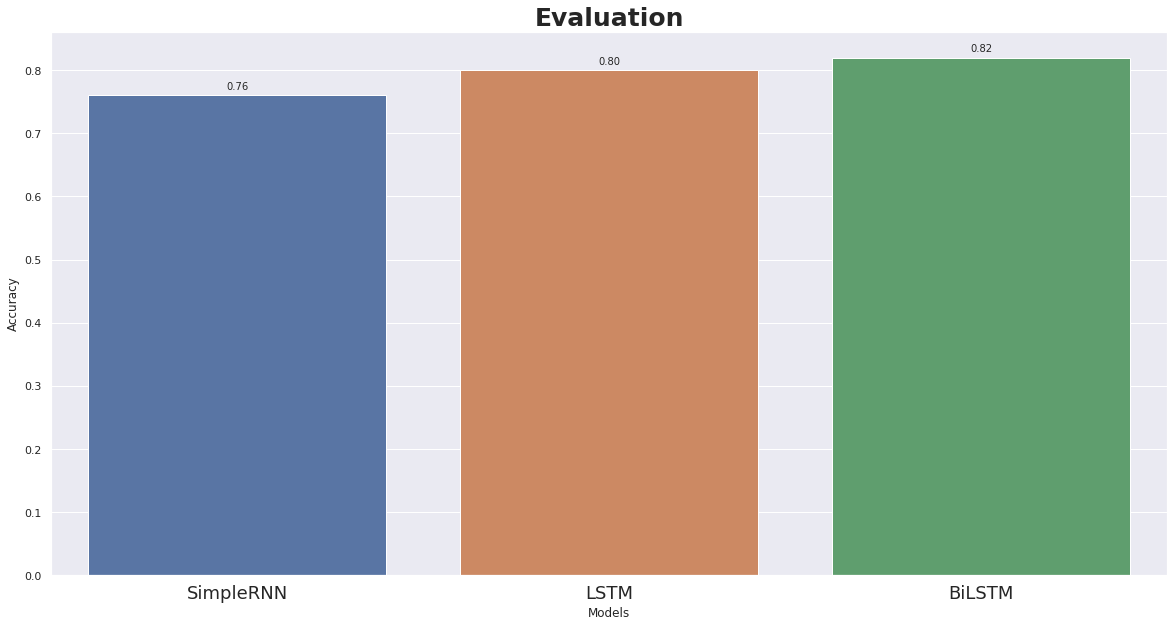

In [71]:
accuracy_simple_rnn = accuracy_score(y_test, simpleRNN.predict_classes(X_test_sqns))
accuracy_lstm = accuracy_score(y_test, lstm_model.predict_classes(X_test_sqns))
accuracy_bi_lstm = accuracy_score(y_test, biLSTM.predict_classes(X_test_sqns))

conclusion = pd.DataFrame({'Models':['SimpleRNN', 'LSTM', 'BiLSTM'], 
              'Accuracy':[accuracy_simple_rnn, accuracy_lstm, accuracy_bi_lstm]})
conclusion['Accuracy'] = conclusion['Accuracy'].apply(lambda x: round(x,2))
conclusion.sort_values(by='Accuracy', inplace = True, ascending = True)

plt.figure(figsize=(20,10))
seaborn_plot = sns.barplot(conclusion.Models,conclusion.Accuracy)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Evaluation", weight='bold', size=25)
plt.xticks(size=18)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

In [72]:
print('''Got a accuracy of %d with significant improvement using Bidirectional LSTM model \nas compared with vanilla LSTM model %d and RNN model %d.'''%((conclusion.Accuracy[2]*100),(conclusion.Accuracy[1]*100),(conclusion.Accuracy[0]*100)))

Got a accuracy of 82 with significant improvement using Bidirectional LSTM model 
as compared with vanilla LSTM model 80 and RNN model 76.


### Since Bidirectional LSTM Model gives best accuracy than others, so making predicitons using Bidirectional LSTM Model

In [73]:
print(colored('\x1B[1mPrediciting via biLST Mmodel','magenta'))
y_pred = biLSTM.predict_classes(X_test_sqns)
correct = [pred == true for pred, true in zip(y_pred, y_test)]

Prediciting via biLST Mmodel


In [74]:
print(colored('\x1B[1mGetting miscalssified sacarsm','magenta'))
true_c = []
false_c = []
hl = []

for i in range(len(correct)):
  if (correct[i]) != True:
    hl.append(X_test[i])
    true_c.append(y_test[i])
    false_c.append(y_pred[i])

Getting miscalssified sacarsm


In [75]:
print(colored('\x1B[1mTotal number of miscalssified classes from test set are %d amoung %d classes'%(len(false_c),len(X_test)),'magenta'))

Total number of miscalssified classes from test set are 195 amoung 1069 classes


In [76]:
print(colored('\x1B[1mPredicition','magenta'))
for i in range(50):
  x=random.choice(range(len(X_test)))
  y_pred = biLSTM.predict_classes(X_test_sqns)
  print('\x1B[1m\nSentence with Actual Target: %d'%y_test[x],"positve" if y_test[x]==1 else "negetive")
  print('Sentence with Predicted Target: %d'%y_pred[x],"positve" if y_pred[x]==1 else "negetive")
  print("Correctly classified" if y_pred[x]==y_test[x] else "Inorrectly classified")
  print('Sentence',X_test[x])

Predicition

Sentence with Actual Target: 1 positve
Sentence with Predicted Target: 1 positve
Correctly classified
Sentence blender leave keep cat company

Sentence with Actual Target: 0 negetive
Sentence with Predicted Target: 0 negetive
Correctly classified
Sentence bill clinton shoot republicans strongly support obamacare

Sentence with Actual Target: 0 negetive
Sentence with Predicted Target: 0 negetive
Correctly classified
Sentence funny parent tweet mom dad say twitter week

Sentence with Actual Target: 0 negetive
Sentence with Predicted Target: 0 negetive
Correctly classified
Sentence u swimmer charge false testimony vandalism brazil police

Sentence with Actual Target: 0 negetive
Sentence with Predicted Target: 0 negetive
Correctly classified
Sentence literally every sentence ted cruz quote misleading false

Sentence with Actual Target: 0 negetive
Sentence with Predicted Target: 1 positve
Inorrectly classified
Sentence fortes gross beard test result make want shave

Sentence wi